### Vary dimension $p$
Vary the number of nodes $p$ and observe the error, bias, and time to run.
The number of samples scales with $(p+s) \log p$ for $s$ denoting the sparsity of the precision matrix.

In [1]:
from utils import *
from opt import *
from time import perf_counter


In [19]:
edge_prob = .1
# DIM_RANGE = np.arange(10,50+1,10)
DIM_RANGE = [100,150,200,250,300,350,400,450,500]
DIM_RANGE = np.arange(20,100+1,10)
DIM_RANGE = np.arange(50,250+1,25)
SPARS_RANGE = [ edge_prob*p*(p-1) for p in DIM_RANGE ]
# SAMPLE_RANGE = [ int((p + SPARS_RANGE[i])*np.log(p)) for i,p in enumerate(DIM_RANGE) ]
SAMPLE_RANGE = [ int(1e5) for p in DIM_RANGE ]
num_params = len(DIM_RANGE)

g = 2

mu1 = 1
mu2 = 1000
epsilon = 1e-6
bias_type = 'dp'
eta = .02
iters = 1000
EARLY_STOPPING = True

num_trials = 1

mu1_RANGE = [ mu1 * np.sqrt(np.log(p)/SAMPLE_RANGE[i]) for i,p in enumerate(DIM_RANGE) ]


In [20]:
Theta_glasso_ests = [[None for i in range(num_params)] for t in range(num_trials)]
Theta_dp_ests = [[None for i in range(num_params)] for t in range(num_trials)]
Theta_nodewise_ests = [[None for i in range(num_params)] for t in range(num_trials)]
# Theta_cvxpy_ests = [[None for i in range(num_params)] for t in range(num_trials)]

bias_true = np.zeros((num_trials,num_params))

frob_err_glasso = np.zeros((num_trials,num_params))
f1_score_glasso = np.zeros((num_trials,num_params))
time_run_glasso = np.zeros((num_trials,num_params))
bias_glasso = np.zeros((num_trials,num_params))

frob_err_dp = np.zeros((num_trials,num_params))
f1_score_dp = np.zeros((num_trials,num_params))
time_run_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_err_nodewise = np.zeros((num_trials,num_params))
f1_score_nodewise = np.zeros((num_trials,num_params))
time_run_nodewise = np.zeros((num_trials,num_params))
bias_nodewise = np.zeros((num_trials,num_params))

# frob_err_cvxpy = np.zeros((num_trials,num_params))
# f1_score_cvxpy = np.zeros((num_trials,num_params))
# time_run_cvxpy = np.zeros((num_trials,num_params))
# bias_cvxpy = np.zeros((num_trials,num_params))

for i,p in enumerate(DIM_RANGE):
    n = SAMPLE_RANGE[i]
    mu1 = mu1_RANGE[i]

    for t in range(num_trials):
        print(f"Dimension p = {p} | No. samples n = {n} | Trial {t+1} of {num_trials}")

        z = np.ones(p, dtype=int)
        z[:int(p/2)] = 0
        Z = np.eye(g)[z].T

        # A = generate_connected_er(p,edge_prob)
        A = generate_ksbm(p, 2, edge_prob*2/3, edge_prob/2*3, z)
        Sigma, Theta = create_mtp2_cov(A)
        Theta_od = Theta*(1-np.eye(p))
        X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
        Sigma_hat = X.T@X/n

        bias_true[t,i] = compute_dp2(Theta,Z)

        # tic = perf_counter()
        # Theta_cvxpy = FairGLASSO_cvx(Sigma_hat, Z, mu1, mu2, epsilon, 'dp')
        # Theta_cvxpy_od = Theta_cvxpy*(1-np.eye(p))
        # Theta_cvxpy_ests[t][i] = Theta_cvxpy.copy()
        # toc = perf_counter()
        # frob_err_cvxpy[t,i] = compute_frob_err(Theta_cvxpy_od, Theta_od)
        # f1_score_cvxpy[t,i] = compute_f1_score(Theta_cvxpy, Theta,.1)
        # time_run_cvxpy[t,i] = np.abs(toc-tic)
        # # bias_cvxpy[t,i] = compute_dp2(Theta_cvxpy, Z) 
        # bias_cvxpy[t,i] = compute_dp2(Theta_cvxpy, Z) / np.mean(mat2lowtri(np.abs(Theta_cvxpy))) if np.mean(mat2lowtri(np.abs(Theta_cvxpy))) else 0
        # print( '    ' +
        #     'CVXPY: ' + 
        #     f'Err: {frob_err_cvxpy[t,i]:.4f} | ' +
        #     f'F1: {f1_score_cvxpy[t,i]:.4f} | ' +
        #     f'Time: {time_run_cvxpy[t,i]:.4f} | ' +
        #     f'Bias: {bias_cvxpy[t,i]:.4f}')

        tic = perf_counter()
        Theta_glasso = node_FGL_fista(Sigma_hat, mu1, eta, 0, Z, 'dp', epsilon, iters, EARLY_STOPPING)
        Theta_glasso_od = Theta_glasso*(1-np.eye(p))
        Theta_glasso_ests[t][i] = Theta_glasso.copy()
        toc = perf_counter()
        frob_err_glasso[t,i] = compute_frob_err(Theta_glasso_od, Theta_od)
        f1_score_glasso[t,i] = compute_f1_score(Theta_glasso, Theta,.1)
        time_run_glasso[t,i] = np.abs(toc-tic)
        # bias_glasso[t,i] = compute_dp2(Theta_glasso, Z) 
        bias_glasso[t,i] = compute_dp2(Theta_glasso, Z) / np.mean(mat2lowtri(np.abs(Theta_glasso))) if np.mean(mat2lowtri(np.abs(Theta_glasso))) else 0
        print( '    ' +
            'GLASSO: ' + 
            f'Err: {frob_err_glasso[t,i]:.4f} | ' +
            f'F1: {f1_score_glasso[t,i]:.4f} | ' +
            f'Time: {time_run_glasso[t,i]:.4f} | ' +
            f'Bias: {bias_glasso[t,i]:.4f}')

        tic = perf_counter()
        Theta_dp = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'dp', epsilon, iters, EARLY_STOPPING)
        Theta_dp_od = Theta_dp*(1-np.eye(p))
        Theta_dp_ests[t][i] = Theta_dp.copy()
        toc = perf_counter()
        frob_err_dp[t,i] = compute_frob_err(Theta_dp_od, Theta_od)
        f1_score_dp[t,i] = compute_f1_score(Theta_dp, Theta,.1)
        time_run_dp[t,i] = np.abs(toc-tic)
        # bias_dp[t,i] = compute_dp2(Theta_dp, Z) 
        bias_dp[t,i] = compute_dp2(Theta_dp, Z) / np.mean(mat2lowtri(np.abs(Theta_dp))) if np.mean(mat2lowtri(np.abs(Theta_dp))) else 0
        print( '    ' +
            'DP:     ' + 
            f'Err: {frob_err_dp[t,i]:.4f} | ' +
            f'F1: {f1_score_dp[t,i]:.4f} | ' +
            f'Time: {time_run_dp[t,i]:.4f} | ' +
            f'Bias: {bias_dp[t,i]:.4f}')

        tic = perf_counter()
        Theta_nodewise = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'nodewise', epsilon, iters, EARLY_STOPPING)
        Theta_nodewise_od = Theta_nodewise*(1-np.eye(p))
        Theta_nodewise_ests[t][i] = Theta_nodewise.copy()
        toc = perf_counter()
        frob_err_nodewise[t,i] = compute_frob_err(Theta_nodewise_od, Theta_od)
        f1_score_nodewise[t,i] = compute_f1_score(Theta_nodewise, Theta,.1)
        time_run_nodewise[t,i] = np.abs(toc-tic)
        # bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z) 
        bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z) / np.mean(mat2lowtri(np.abs(Theta_nodewise))) if np.mean(mat2lowtri(np.abs(Theta_nodewise))) else 0
        print( '    ' +
            'Nw. DP: ' + 
            f'Err: {frob_err_nodewise[t,i]:.4f} | ' +
            f'F1: {f1_score_nodewise[t,i]:.4f} | ' +
            f'Time: {time_run_nodewise[t,i]:.4f} | ' +
            f'Bias: {bias_nodewise[t,i]:.4f}')


Dimension p = 50 | No. samples n = 100000 | Trial 1 of 1
    GLASSO: Err: 0.1728 | F1: 0.4717 | Time: 0.5220 | Bias: 0.0738
    DP:     Err: 0.3318 | F1: 0.5091 | Time: 0.5405 | Bias: 0.0000
    Nw. DP: Err: 0.3741 | F1: 0.4860 | Time: 11.0147 | Bias: 0.0000
Dimension p = 75 | No. samples n = 100000 | Trial 1 of 1
    GLASSO: Err: 0.2346 | F1: 1.0000 | Time: 0.8910 | Bias: 0.0263
    DP:     Err: 0.3196 | F1: 1.0000 | Time: 0.8642 | Bias: 0.0001
    Nw. DP: Err: 0.3802 | F1: 1.0000 | Time: 22.2460 | Bias: 0.0000
Dimension p = 100 | No. samples n = 100000 | Trial 1 of 1
    GLASSO: Err: 0.3863 | F1: 1.0000 | Time: 1.2731 | Bias: 0.0215
    DP:     Err: 0.4589 | F1: 1.0000 | Time: 1.3369 | Bias: 0.0001
    Nw. DP: Err: 0.4939 | F1: 1.0000 | Time: 39.4042 | Bias: 0.0000
Dimension p = 125 | No. samples n = 100000 | Trial 1 of 1
    GLASSO: Err: 0.5005 | F1: 1.0000 | Time: 2.1113 | Bias: 0.0164
    DP:     Err: 0.5537 | F1: 1.0000 | Time: 2.0516 | Bias: 0.0002
    Nw. DP: Err: 0.5760 | F1: 

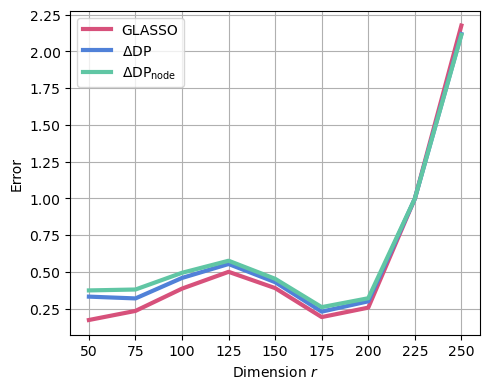

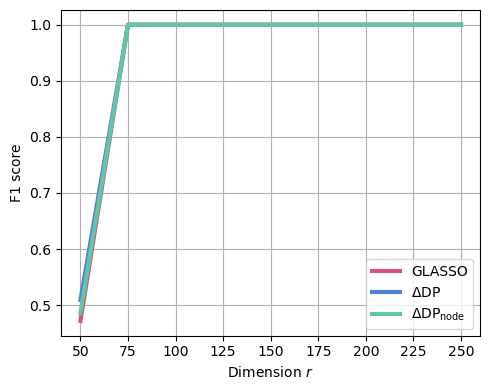

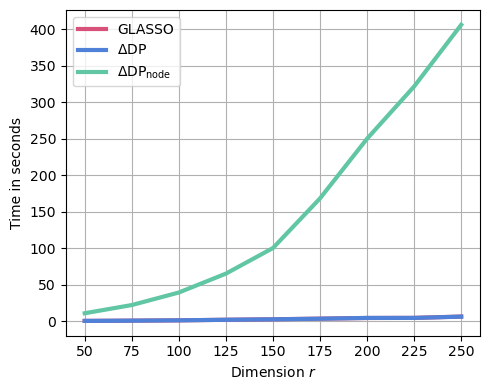

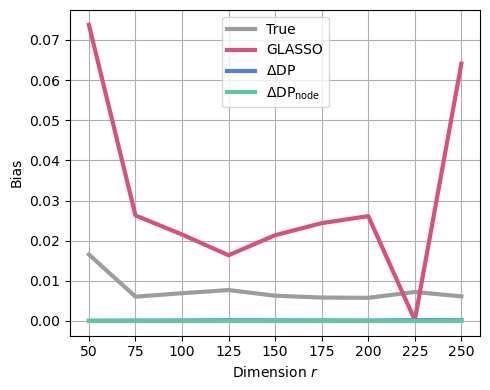

In [22]:
x_label = r'Dimension $r$'
x_range = DIM_RANGE

plt_args = { 'linewidth':3 }

y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = frob_err_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = frob_err_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = frob_err_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = frob_err_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



y_label = 'F1 score'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = f1_score_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = f1_score_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = f1_score_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = f1_score_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Time in seconds'
y_range = time_run_glasso.mean(0)
clr = greens[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

# y_range = time_run_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = time_run_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = time_run_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = time_run_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = bias_true.mean(0)
ax.plot(x_range, y_range, c=grays[10], **plt_args, label='True')

# y_range = bias_cvxpy.mean(0)
# ax.plot(x_range, y_range, c=purples[10], **plt_args, label='CVXPY')

y_range = bias_glasso.mean(0)
# y_range = bias_glasso.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = bias_dp.mean(0)
# y_range = bias_dp.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = bias_nodewise.mean(0)
# y_range = bias_nodewise.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

